### Import required libraries

In [17]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import scipy.stats as stats

### Setup plotting style

In [18]:
# Use a compatible matplotlib style and seaborn settings
plt.style.use('default')  # Use default matplotlib style
sns.set_theme(style="darkgrid")  # Modern seaborn theme setting
sns.set_palette("husl")
%matplotlib inline

# Additional styling for better plots
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

### Load the data

In [19]:
'''
    Test Case 1:
          - Train client is a Laptop connected to 5G network
          - Web client is a Laptop connected to 5G network
'''
#filename =  './29_08_2025/pre_processed/processed_Train_Client(Laptop)_Web_Client(Laptop)_e1c07b43-9e1e-4438-ade8-a320a030e494_Latency.json'


'''
    Test Case 2:
          - Train client is a Laptop connected to 5G network
          - Web client is a Phone connected to 5G network
'''
# filename =  './29_08_2025/pre_processed/processed_Train_Client(Laptop)_Web_Client(Mobile_DE)_5d6a5a85-6566-45b9-8b57-48e886539e0b_Latency.json'


'''
    Test Case 3:
          - Train client is a Laptop connected to 5G network (Germany)
          - Web client is a Phone connected to 4G network (Bangladesh)
'''
# filename =  './29_08_2025/pre_processed/processed_Train_Client(Laptop)_Web_Client(Mobile_BD)_1bdb4d47-a2e0-4148-a721-796cf6ff755b_Latency.json'

'''
    Test Case 4:
          - Train client is reakt-Tiny connected to Wifi network
          - Web client is a Laptop connected to Wifi network
'''
# filename =  './11_12_2025/train_e127f95e-e9a0-46d4-9ac0-6b9783533ec2_latency_1765452450000_1765452650000.json'

'''
    Test Case 5:
          - Train client is reakt-Tiny connected to Wifi network
          - Web client is a Laptop connected to Wifi network
          - date: 18th December 2025
'''
# filename =  './2025_12_18/train_72275261-bd04-436f-bc49-39af129914e9_latency_1766056830000_1766057039000.json'

'''
    Test Case 6:
          - Train client is reakt-Tiny connected to Wifi network
          - Web client is a Laptop connected to Wifi network
          - date: 15th January 2026
'''
# filename =  './2026_01_16/train_14c82344-01dc-41da-af98-95a5ea67f115_latency_1768569238000_1768569346000.json'

'''
    Test Case 7:
          - Scenario 01
          - Train client is reakt-Tiny connected to Wifi network
          - Web client is a Samsung S23 Ultra connected to Wifi network
          - date: 21th January 2026
'''
# filename = './2026_01_21/20260116_171827_Scene_01/latency_video_20260116_171828.json'

'''
    Test Case 7:
          - Scenario 02
          - Train client is reakt-Tiny connected to Wifi network
          - Web client is a Samsung S23 Ultra connected to Wifi network
          - date: 21th January 2026
'''
filename = './2026_01_21/20260116_172945_Scene_02/latency_video_20260116_172945.json'

with open(filename, 'r') as file:
    data = json.load(file)

print(f"Data loaded successfully from {filename}")
print(f"Data type: {type(data)}")
print(f"Data keys: {list(data.keys()) if isinstance(data, dict) else 'Not a dictionary'}")

# Convert to DataFrames for easier analysis
telemetry_df = pd.DataFrame(data['telemetryLatencies'])
video_df = pd.DataFrame(data['videoLatencies'])

# export video_df to csv
video_df.to_csv("video_latency_analysis.csv", index=False)

# Create a summary DataFrame from statistics
protocols = ['websocket', 'webtransport', 'mqtt']
stats_data = []
for protocol in protocols:
    stats_data.append({
        'protocol': protocol,
        'count': data['statistics'][protocol]['count'],
        'avg': data['statistics'][protocol]['avg'],
        'min': data['statistics'][protocol]['min'],
        'max': data['statistics'][protocol]['max']
    })
stats_df = pd.DataFrame(stats_data)

Data loaded successfully from ./2026_01_21/20260116_172945_Scene_02/latency_video_20260116_172945.json
Data type: <class 'dict'>
Data keys: ['exportTime', 'statistics', 'telemetryLatencies', 'videoLatencies']


#### 1.1 Basic Statistics Comparison

In [20]:
print("Protocol Statistics Comparison:")
print(stats_df)

Protocol Statistics Comparison:
       protocol  count            avg  min        max
0     websocket      0       0.000000    0          0
1  webtransport      0       0.000000    0          0
2          mqtt    781  546941.732394   21  427140025


#### 1.2 Visualization of protocol performance

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(25, 8))  # Increased figure height

# Average latency by protocol with data count labels
bars_avg = axes[0].bar(stats_df['protocol'], stats_df['avg'])
axes[0].set_title('Average Latency by Protocol', fontsize=12, fontweight='bold', pad=20)
axes[0].set_ylabel('Latency (ms)')
axes[0].tick_params(axis='x', rotation=45)

# Add count labels on top of average latency bars
for i, (bar, row) in enumerate(zip(bars_avg, stats_df.itertuples())):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{row.avg:.1f}ms\n({row.count} samples)',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

# Min-Max latency range
for i, row in stats_df.iterrows():
    axes[1].plot([row['protocol'], row['protocol']], [row['min'], row['max']],
                   marker='o', linewidth=3, markersize=8)

    # Add labels for min and max values
    # Label for maximum value (top)
    axes[1].text(i, row['max'] + (row['max'] - row['min']) * 0.05,
                f'Max: {row["max"]:.1f}ms',
                ha='center', va='bottom', fontsize=10, fontweight='bold',
                bbox=dict(boxstyle="round,pad=0.3", facecolor='lightblue', alpha=0.7))

    # Label for minimum value (bottom)
    axes[1].text(i, row['min'] - (row['max'] - row['min']) * 0.05,
                f'Min: {row["min"]:.1f}ms',
                ha='center', va='top', fontsize=10, fontweight='bold',
                bbox=dict(boxstyle="round,pad=0.3", facecolor='lightcoral', alpha=0.7))

axes[1].set_title('Latency Range (Min-Max) by Protocol', fontsize=12, fontweight='bold', pad=20)
axes[1].set_ylabel('Latency (ms)')
axes[1].tick_params(axis='x', rotation=45)

# Check for missing values in telemetry data
print("Missing values in telemetry data:")
print(f"MQTT: {telemetry_df['mqtt'].isna().sum()}")
print(f"WebTransport: {telemetry_df['wt'].isna().sum()}")
print(f"WebSocket: {telemetry_df['ws'].isna().sum()}")

# Calculate missing percentages
total_records = len(telemetry_df)
missing_percentages = {
    'MQTT': (telemetry_df['mqtt'].isna().sum() / total_records) * 100,
    'WebTransport': (telemetry_df['wt'].isna().sum() / total_records) * 100,
    'WebSocket': (telemetry_df['ws'].isna().sum() / total_records) * 100
}

# Missing percentage by protocol
protocols_missing = list(missing_percentages.keys())
percentages = list(missing_percentages.values())

bars = axes[2].bar(protocols_missing, percentages)
axes[2].set_title('Missing Data Percentage by Protocol', fontsize=12, fontweight='bold', pad=20)
axes[2].set_ylabel('Missing Percentage (%)')
axes[2].tick_params(axis='x', rotation=45)

# Add percentage labels on top of bars
for bar, percentage in zip(bars, percentages):
    height = bar.get_height()
    axes[2].text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{percentage:.1f}%', ha='center', va='bottom')

# Set y-axis limit for better visualization
axes[2].set_ylim(0, max(percentages) * 1.2 if max(percentages) > 0 else 10)

plt.tight_layout()
plt.subplots_adjust(top=0.85)  # Add extra space at the top for the titles
plt.show()

print(f"\nMissing data percentages:")
for protocol, percentage in missing_percentages.items():
    print(f"{protocol}: {percentage:.2f}%")

# Print telemetry data count summary
print(f"\nTelemetry data processed by each protocol:")
for _, row in stats_df.iterrows():
    print(f"{row['protocol']}: {row['count']} samples")

#### 2.1 Time Series analysis of telemetry data

In [ ]:
# Check data shape and info
print(f"\nTelemetry data shape: {telemetry_df.shape}")
print(f"Sequence ID range: {telemetry_df['sequence_id'].min()} - {telemetry_df['sequence_id'].max()}")

# Display first few rows to understand the data structure
print("\nFirst 10 rows of telemetry data:")
print(telemetry_df.head(10))

In [ ]:
# Comparison: Original data with gaps vs Interpolated data
fig, ax1 = plt.subplots(1, 1, figsize=(20, 8))

# Original data (with potential gaps)
ax1.plot(telemetry_df['sequence_id'], telemetry_df['mqtt'], marker='o', label='MQTT', linewidth=2, markersize=4, alpha=0.7)
ax1.plot(telemetry_df['sequence_id'], telemetry_df['wt'], marker='s', label='WebTransport', linewidth=2, markersize=4, alpha=0.7)
ax1.plot(telemetry_df['sequence_id'], telemetry_df['ws'], marker='^', label='WebSocket', linewidth=2, markersize=4, alpha=0.7)
ax1.set_xlabel('Sequence ID')
ax1.set_ylabel('Latency (ms)')
ax1.set_title('Original Telemetry Data (with potential gaps)', fontsize=14, fontweight='bold', pad=20)
ax1.legend()
ax1.grid(True, alpha=0.3)

plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Add extra space at the top for the title
plt.show()

#### 2.2 Cumulative Latency Analysis for telemetry data

In [ ]:
# Create cumulative latency data with interpolation for null values
telemetry_clean_cumulative = telemetry_df.copy()

# First, interpolate null values for each protocol
print("Before interpolation:")
print(f"MQTT null values: {telemetry_clean_cumulative['mqtt'].isna().sum()}")
print(f"WebTransport null values: {telemetry_clean_cumulative['wt'].isna().sum()}")
print(f"WebSocket null values: {telemetry_clean_cumulative['ws'].isna().sum()}")

# Interpolate missing values using linear interpolation
telemetry_clean_cumulative['mqtt'] = telemetry_clean_cumulative['mqtt'].interpolate(method='linear')
telemetry_clean_cumulative['wt'] = telemetry_clean_cumulative['wt'].interpolate(method='linear')
telemetry_clean_cumulative['ws'] = telemetry_clean_cumulative['ws'].interpolate(method='linear')

print("\nAfter interpolation:")
print(f"MQTT null values: {telemetry_clean_cumulative['mqtt'].isna().sum()}")
print(f"WebTransport null values: {telemetry_clean_cumulative['wt'].isna().sum()}")
print(f"WebSocket null values: {telemetry_clean_cumulative['ws'].isna().sum()}")

# Calculate cumulative latencies for each protocol
telemetry_clean_cumulative['mqtt_cumulative'] = telemetry_clean_cumulative['mqtt'].cumsum()
telemetry_clean_cumulative['wt_cumulative'] = telemetry_clean_cumulative['wt'].cumsum()
telemetry_clean_cumulative['ws_cumulative'] = telemetry_clean_cumulative['ws'].cumsum()

print("\nCumulative latency data created successfully!")
print(f"Shape: {telemetry_clean_cumulative.shape}")
print("\nFirst 10 rows of cumulative data:")
print(telemetry_clean_cumulative[['sequence_id', 'mqtt_cumulative', 'wt_cumulative', 'ws_cumulative']].head(10))
print("\nLast 10 rows of cumulative data:")
print(telemetry_clean_cumulative[['sequence_id', 'mqtt_cumulative', 'wt_cumulative', 'ws_cumulative']].tail(10))

In [ ]:
# Plot cumulative latencies
plt.figure(figsize=(20, 8))
plt.plot(telemetry_clean_cumulative['sequence_id'], telemetry_clean_cumulative['mqtt_cumulative'],
         marker='o', label='MQTT (Cumulative)', linewidth=3, markersize=4)
plt.plot(telemetry_clean_cumulative['sequence_id'], telemetry_clean_cumulative['wt_cumulative'],
         marker='s', label='WebTransport (Cumulative)', linewidth=3, markersize=4)
plt.plot(telemetry_clean_cumulative['sequence_id'], telemetry_clean_cumulative['ws_cumulative'],
         marker='^', label='WebSocket (Cumulative)', linewidth=3, markersize=4)

plt.xlabel('Sequence ID', fontsize=12)
plt.ylabel('Cumulative Latency (ms)', fontsize=12)
plt.title('Cumulative Telemetry Latencies Over Time', fontsize=14, fontweight='bold', pad=20)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Add extra space at the top for the title
plt.show()

#### 3. Video Frame Latency Analysis

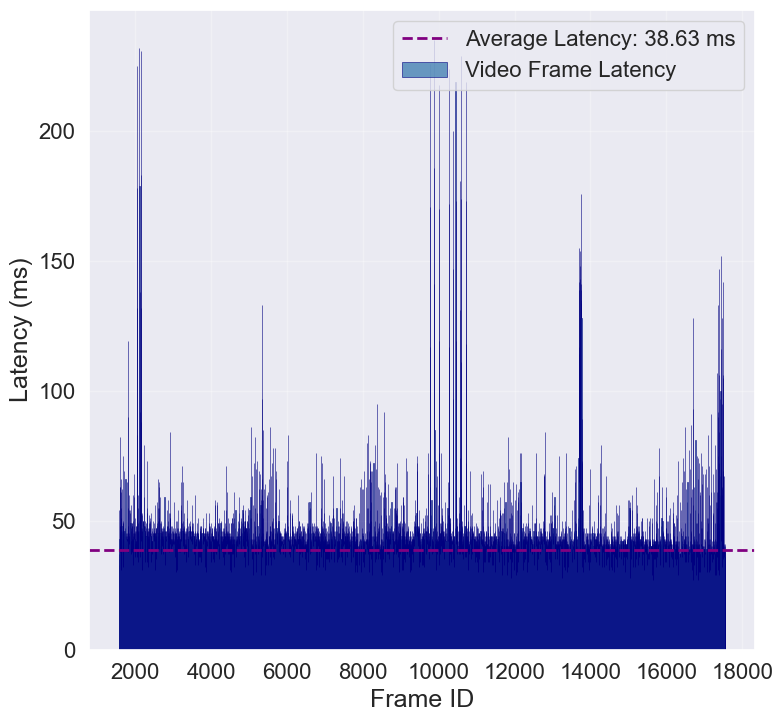

In [21]:
# 3.1 Time series analysis of video latencies
plt.figure(figsize=(8, 8))

# Calculate average latency
avg_latency = video_df['latency'].mean()

# Latency over frame sequence (bar chart with thinner bars for better visibility)
plt.bar(video_df['frameId'], video_df['latency'], width=1.0, alpha=0.8, 
        color='steelblue', edgecolor='navy', linewidth=0.5, label='Video Frame Latency')

# Add horizontal line for average latency
plt.axhline(y=avg_latency, color='purple', linestyle='--', linewidth=2,
           label=f'Average Latency: {avg_latency:.2f} ms')

plt.xlabel('Frame ID', fontsize=18)
plt.ylabel('Latency (ms)', fontsize=18)
plt.legend(fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Add extra space at the top for the title
plt.show()

First received frame ID: 1578
Last received frame ID: 17547
Total expected frames in sequence: 15970
Number of received frames: 15970
Number of missing frames: 0
Missing frame percentage: 0.00%

Missing frame IDs: None


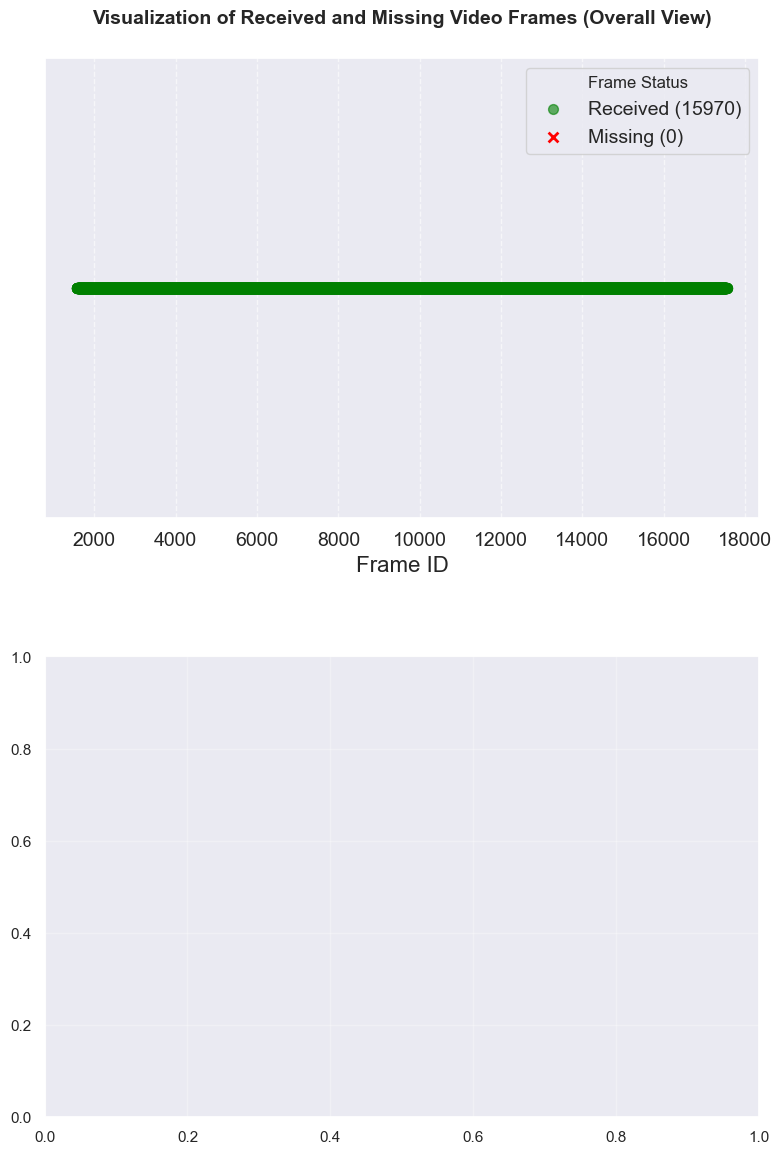

In [22]:
# 3.2 Analysis of missing video frames
if not video_df.empty:
    # Find the first and last frame IDs
    first_frame_id = video_df['frameId'].min()
    last_frame_id = video_df['frameId'].max()

    # Calculate the total number of expected frames
    total_expected_frames = last_frame_id - first_frame_id + 1

    # Calculate the number of received frames
    received_frames_count = len(video_df)

    # Calculate the number of missing frames
    missing_frames_count = total_expected_frames - received_frames_count

    print(f"First received frame ID: {first_frame_id}")
    print(f"Last received frame ID: {last_frame_id}")
    print(f"Total expected frames in sequence: {total_expected_frames}")
    print(f"Number of received frames: {received_frames_count}")
    print(f"Number of missing frames: {missing_frames_count}")
    print(f"Missing frame percentage: {(missing_frames_count/total_expected_frames)*100:.2f}%")

    # Identify the missing frame IDs
    expected_frame_ids = set(range(first_frame_id, last_frame_id + 1))
    received_frame_ids = set(video_df['frameId'])
    missing_frame_ids = sorted(list(expected_frame_ids - received_frame_ids))

    print(f"\nMissing frame IDs: {missing_frame_ids if missing_frames_count > 0 else 'None'}")

    # Create visualizations
    fig, axes = plt.subplots(2, 1, figsize=(8, 12))  # Increased figure height

    # 1. Overall view with improved markers
    all_frames = pd.DataFrame({'frameId': list(range(first_frame_id, last_frame_id + 1))})
    all_frames['status'] = 'Missing'
    all_frames.loc[all_frames['frameId'].isin(received_frame_ids), 'status'] = 'Received'

    # Plot with larger, more visible markers
    received_data = all_frames[all_frames['status'] == 'Received']
    missing_data = all_frames[all_frames['status'] == 'Missing']

    axes[0].scatter(received_data['frameId'], [1]*len(received_data), 
                   c='green', alpha=0.6, s=50, marker='o', label=f'Received ({len(received_data)})')
    axes[0].scatter(missing_data['frameId'], [1]*len(missing_data), 
                   c='red', s=50, marker='x', label=f'Missing ({len(missing_data)})', linewidths=2)

    axes[0].set_title('Visualization of Received and Missing Video Frames (Overall View)', 
                     fontsize=14, fontweight='bold', pad=25)  # Increased padding
    axes[0].set_xlabel('Frame ID', fontsize=16)
    axes[0].set_yticks([])
    axes[0].set_ylabel('')
    axes[0].legend(title='Frame Status', fontsize=14)
    axes[0].tick_params(axis='both', which='major', labelsize=14)
    axes[0].grid(True, axis='x', linestyle='--', alpha=0.6)

    # 2. Missing frames density visualization
    if missing_frame_ids:
        # Create bins to show missing frame density
        bin_size = 200  # frames per bin
        bins = range(first_frame_id, last_frame_id + bin_size, bin_size)
        missing_counts, bin_edges = np.histogram(missing_frame_ids, bins=bins)
        bin_centers = [(bin_edges[i] + bin_edges[i+1]) / 2 for i in range(len(bin_edges)-1)]

        axes[1].bar(bin_centers, missing_counts, width=bin_size*0.8, alpha=0.7, color='red', edgecolor='darkred')
        axes[1].set_title(f'Missing Frame Density (Bin Size: {bin_size} frames)', 
                         fontsize=14, fontweight='bold', pad=25)  # Increased padding
        axes[1].set_xlabel('Frame ID Range', fontsize=16)
        axes[1].set_ylabel('Number of Missing Frames', fontsize=16)
        axes[1].tick_params(axis='both', which='major', labelsize=14)
        axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.subplots_adjust(top=0.92, hspace=0.3)  # Add extra space at top and between subplots
    plt.show()

    # Print summary statistics
    if missing_frame_ids:
        print(f"\nMissing Frame Analysis:")
        print(f"- First missing frame: {min(missing_frame_ids)}")
        print(f"- Last missing frame: {max(missing_frame_ids)}")
        print(f"- Average gap between consecutive missing frames: {np.mean(np.diff(missing_frame_ids)):.1f}")
        if len(missing_frame_ids) > 1:
            print(f"- Largest gap between consecutive missing frames: {max(np.diff(missing_frame_ids))}")

else:
    print("Video data is empty. Cannot perform missing frame analysis.")

C:\Users\rajib\AppData\Local\Temp\ipykernel_28340\3829242471.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = plt.boxplot([video_df['latency'].values],


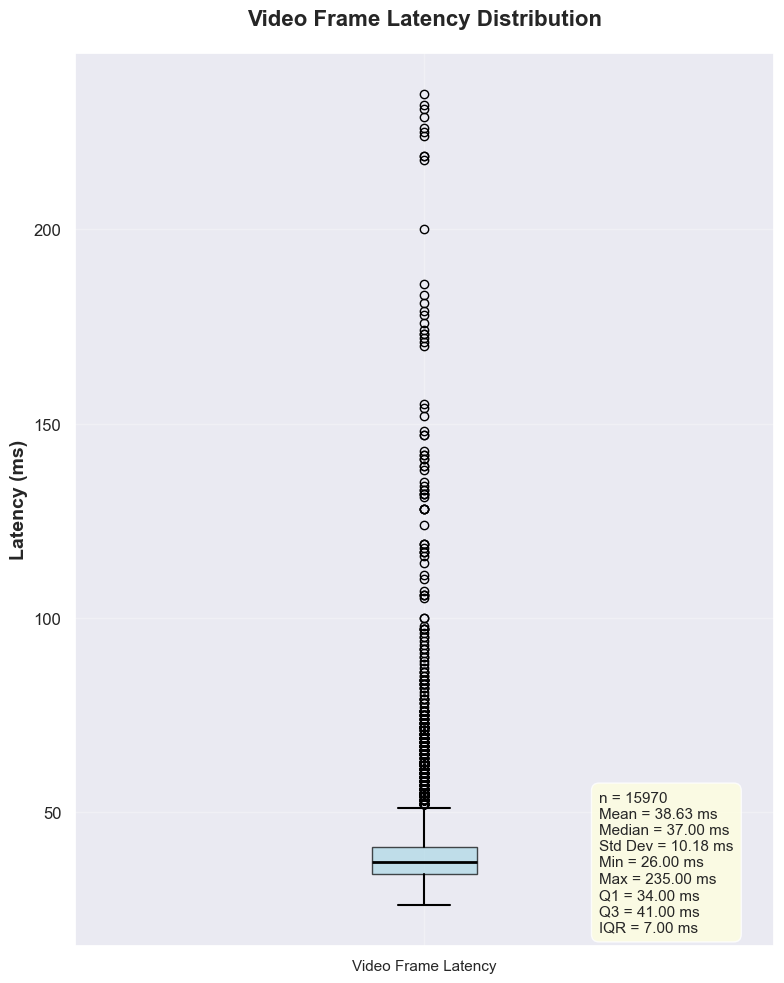

Video Frame Latency Statistics:
  Total frames: 15970
  Mean: 38.63 ms
  Median: 37.00 ms
  Std Dev: 10.18 ms
  Min: 26.00 ms
  Max: 235.00 ms
  Q1 (25%): 34.00 ms
  Q3 (75%): 41.00 ms
  IQR: 7.00 ms


In [23]:
# 3.3 Box plot  analysis of video latencies
# Create box plot for video frame latencies
plt.figure(figsize=(8, 10))

# Create box plot
box_plot = plt.boxplot([video_df['latency'].values],
                        labels=['Video Frame Latency'],
                        patch_artist=True,
                        showmeans=False,
                        medianprops=dict(color='black', linewidth=2),
                        boxprops=dict(facecolor='lightblue', alpha=0.7),
                        whiskerprops=dict(linewidth=1.5),
                        capprops=dict(linewidth=1.5))

plt.ylabel('Latency (ms)', fontsize=14, fontweight='bold')
plt.title('Video Frame Latency Distribution', fontsize=16, fontweight='bold', pad=20)
plt.yticks(fontsize=12)
plt.grid(True, alpha=0.3, axis='y')

# Add statistics annotations
stats_text = f"n = {len(video_df)}\n"
stats_text += f"Mean = {video_df['latency'].mean():.2f} ms\n"
stats_text += f"Median = {video_df['latency'].median():.2f} ms\n"
stats_text += f"Std Dev = {video_df['latency'].std():.2f} ms\n"
stats_text += f"Min = {video_df['latency'].min():.2f} ms\n"
stats_text += f"Max = {video_df['latency'].max():.2f} ms\n"
stats_text += f"Q1 = {video_df['latency'].quantile(0.25):.2f} ms\n"
stats_text += f"Q3 = {video_df['latency'].quantile(0.75):.2f} ms\n"
stats_text += f"IQR = {video_df['latency'].quantile(0.75) - video_df['latency'].quantile(0.25):.2f} ms"

# Add text box with statistics
plt.text(1.25, video_df['latency'].median(), stats_text,
         fontsize=11, verticalalignment='center',
         bbox=dict(boxstyle='round,pad=0.5', facecolor='lightyellow', alpha=0.8))

plt.tight_layout()
plt.show()

# Print detailed statistics
print("Video Frame Latency Statistics:")
print(f"  Total frames: {len(video_df)}")
print(f"  Mean: {video_df['latency'].mean():.2f} ms")
print(f"  Median: {video_df['latency'].median():.2f} ms")
print(f"  Std Dev: {video_df['latency'].std():.2f} ms")
print(f"  Min: {video_df['latency'].min():.2f} ms")
print(f"  Max: {video_df['latency'].max():.2f} ms")
print(f"  Q1 (25%): {video_df['latency'].quantile(0.25):.2f} ms")
print(f"  Q3 (75%): {video_df['latency'].quantile(0.75):.2f} ms")
print(f"  IQR: {video_df['latency'].quantile(0.75) - video_df['latency'].quantile(0.25):.2f} ms")

C:\Users\rajib\AppData\Local\Temp\ipykernel_28340\3320427462.py:8: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  video_df['second'] = video_df['timestamp'].dt.floor('S')


Bandwidth Usage Statistics:
Total frames analyzed: 15970
Total data transmitted: 63.42 MB
Duration: 780 seconds

Bandwidth per second (Mbps):
  Mean: 0.68 Mbps
  Median: 0.65 Mbps
  Min: 0.08 Mbps
  Max: 1.38 Mbps
  Std Dev: 0.13 Mbps

Average frames per second: 20.4 fps


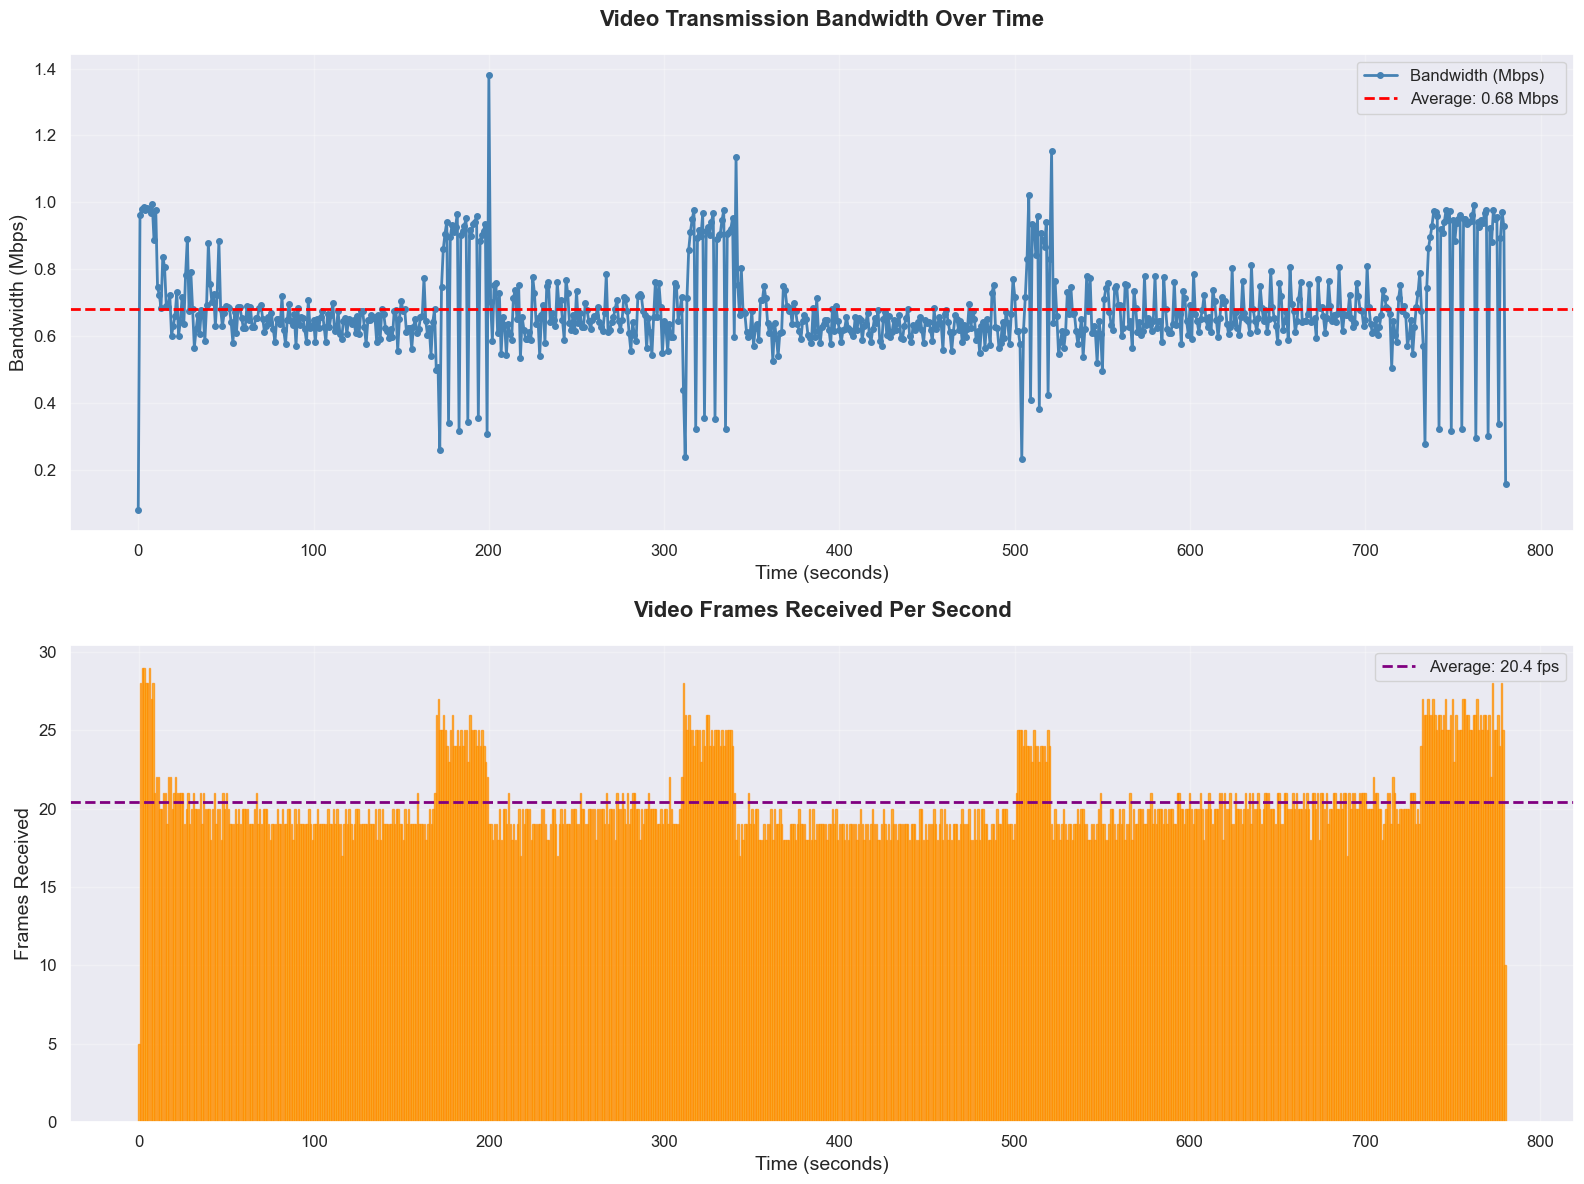


First 10 seconds of bandwidth data:
   time_offset  bandwidth_mbps  frame_count  total_bytes
0          0.0        0.082312            5        10289
1          1.0        0.961088           28       120136
2          2.0        0.980848           29       122606
3          3.0        0.986424           29       123303
4          4.0        0.978416           28       122302
5          5.0        0.981928           28       122741
6          6.0        0.979680           29       122460
7          7.0        0.966936           27       120867
8          8.0        0.993824           28       124228
9          9.0        0.887144           21       110893


In [24]:
# 3.4 Analysis of bandwidth usage in each seconds for video transmission
# video_df has a 'data_size' column in bytes and a 'stored_at' column in timestamp format

# Convert stored_at timestamp to datetime
video_df['timestamp'] = pd.to_datetime(video_df['stored_at'], unit='ms')

# Extract second-level timestamp (remove microseconds for grouping)
video_df['second'] = video_df['timestamp'].dt.floor('S')

# Group by second and calculate total data size (in bytes) per second
bandwidth_per_second = video_df.groupby('second').agg({
    'data_size': 'sum',
    'frameId': 'count'
}).reset_index()

# Rename columns for clarity
bandwidth_per_second.columns = ['second', 'total_bytes', 'frame_count']

# Convert bytes to kilobits per second (Kbps)
bandwidth_per_second['bandwidth_kbps'] = (bandwidth_per_second['total_bytes'] * 8) / 1000

# Convert bytes to megabits per second (Mbps)
bandwidth_per_second['bandwidth_mbps'] = (bandwidth_per_second['total_bytes'] * 8) / (1000 * 1000)

# Create a time index relative to the start (in seconds)
bandwidth_per_second['time_offset'] = (bandwidth_per_second['second'] - bandwidth_per_second['second'].min()).dt.total_seconds()

# Display statistics
print("Bandwidth Usage Statistics:")
print(f"Total frames analyzed: {len(video_df)}")
print(f"Total data transmitted: {video_df['data_size'].sum() / (1024 * 1024):.2f} MB")
print(f"Duration: {bandwidth_per_second['time_offset'].max():.0f} seconds")
print(f"\nBandwidth per second (Mbps):")
print(f"  Mean: {bandwidth_per_second['bandwidth_mbps'].mean():.2f} Mbps")
print(f"  Median: {bandwidth_per_second['bandwidth_mbps'].median():.2f} Mbps")
print(f"  Min: {bandwidth_per_second['bandwidth_mbps'].min():.2f} Mbps")
print(f"  Max: {bandwidth_per_second['bandwidth_mbps'].max():.2f} Mbps")
print(f"  Std Dev: {bandwidth_per_second['bandwidth_mbps'].std():.2f} Mbps")
print(f"\nAverage frames per second: {bandwidth_per_second['frame_count'].mean():.1f} fps")

# Visualization
fig, axes = plt.subplots(2, 1, figsize=(16, 12))

# 1. Bandwidth usage over time (in Mbps)
axes[0].plot(bandwidth_per_second['time_offset'], bandwidth_per_second['bandwidth_mbps'], 
             marker='o', linewidth=2, markersize=4, color='steelblue', label='Bandwidth (Mbps)')
axes[0].axhline(y=bandwidth_per_second['bandwidth_mbps'].mean(), color='red', 
                linestyle='--', linewidth=2, label=f'Average: {bandwidth_per_second["bandwidth_mbps"].mean():.2f} Mbps')
axes[0].set_xlabel('Time (seconds)', fontsize=14)
axes[0].set_ylabel('Bandwidth (Mbps)', fontsize=14)
axes[0].set_title('Video Transmission Bandwidth Over Time', fontsize=16, fontweight='bold', pad=20)
axes[0].legend(fontsize=12)
axes[0].grid(True, alpha=0.3)
axes[0].tick_params(axis='both', which='major', labelsize=12)

# 2. Frames per second over time
axes[1].bar(bandwidth_per_second['time_offset'], bandwidth_per_second['frame_count'], 
            width=0.8, alpha=0.7, color='orange', edgecolor='darkorange')
axes[1].axhline(y=bandwidth_per_second['frame_count'].mean(), color='purple', 
                linestyle='--', linewidth=2, label=f'Average: {bandwidth_per_second["frame_count"].mean():.1f} fps')
axes[1].set_xlabel('Time (seconds)', fontsize=14)
axes[1].set_ylabel('Frames Received', fontsize=14)
axes[1].set_title('Video Frames Received Per Second', fontsize=16, fontweight='bold', pad=20)
axes[1].legend(fontsize=12)
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.show()

# Display first few rows of bandwidth data
print("\nFirst 10 seconds of bandwidth data:")
print(bandwidth_per_second[['time_offset', 'bandwidth_mbps', 'frame_count', 'total_bytes']].head(10))

#### 4. Command Latency Analysis

In [25]:
# load file
# file_command_latency = "./2025_12_18/latency_command.json"
# file_command_latency = "./2026_01_15/latency_command.json"
# file_command_latency = "./2026_01_21/20260116_171827_Scene_01/latency_command_20260116_171828.json"
file_command_latency = "./2026_01_21/20260116_172945_Scene_02/latency_command_20260116_172945.json"

# read the file and parse each line as JSON
command_data = []
with open(file_command_latency, "r") as file:
    for line in file:
        command_data.append(json.loads(line.strip()))

# Display the data
print(f"Total commands loaded: {len(command_data)}")
print("\nFirst few commands:")
for i, cmd in enumerate(command_data[:5]):
    print(f"{i+1}. {cmd}")

# Convert to DataFrame for easier analysis
command_df = pd.DataFrame(command_data)
print("\nDataFrame:")
print(command_df)

# export to csv
command_df.to_csv("command_latency_analysis.csv", index=False)


Total commands loaded: 28

First few commands:
1. {'remote_control_id': 'c1181fa3-a10a-4282-ba71-1578adaa5305', 'command_id': 1, 'instruction': 'CHANGE_DIRECTION', 'latency': 69, 'created_at': 1769008186803, 'received_at': 1768581046845, 'size': 221, 'target_speed': None, 'direction': 'FORWARD', 'quality': None}
2. {'remote_control_id': 'c1181fa3-a10a-4282-ba71-1578adaa5305', 'command_id': 2, 'instruction': 'POWER_ON', 'latency': 94, 'created_at': 1769008186910, 'received_at': 1768581046977, 'size': 191, 'target_speed': None, 'direction': None, 'quality': None}
3. {'remote_control_id': 'c1181fa3-a10a-4282-ba71-1578adaa5305', 'command_id': 3, 'instruction': 'CHANGE_TARGET_SPEED', 'latency': 96, 'created_at': 1769008187013, 'received_at': 1768581047081, 'size': 219, 'target_speed': 6, 'direction': None, 'quality': None}
4. {'remote_control_id': 'c1181fa3-a10a-4282-ba71-1578adaa5305', 'command_id': 4, 'instruction': 'CHANGE_TARGET_SPEED', 'latency': 83, 'created_at': 1769008217122, 'recei

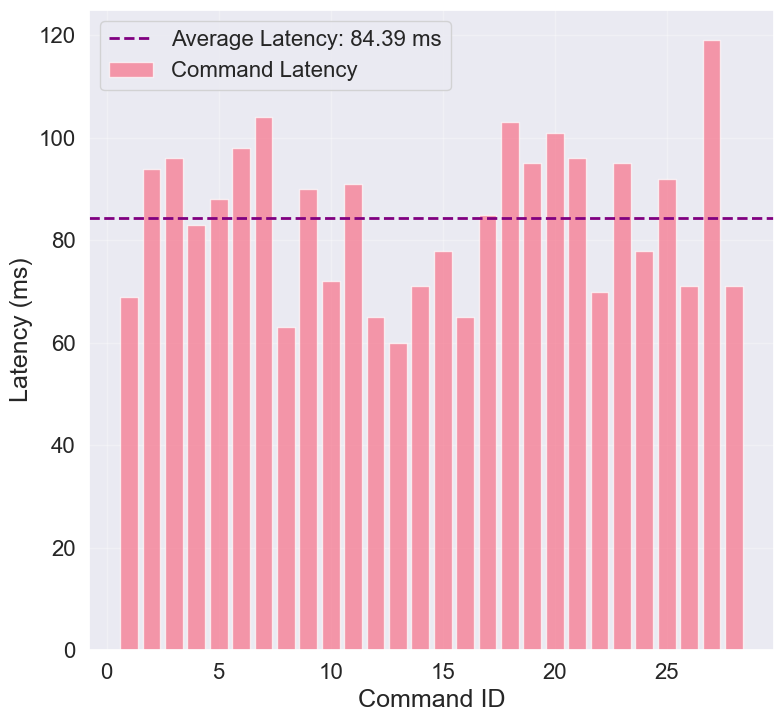

In [26]:
# 4.1 Time series analysis of command latencies
plt.figure(figsize=(8, 8))

# Calculate average latency
avg_latency = command_df['latency'].mean()

# Latency over command sequence (bar chart)
plt.bar(command_df['command_id'], command_df['latency'], width=0.8, alpha=0.7, label='Command Latency')

# Add horizontal line for average latency
plt.axhline(y=avg_latency, color='purple', linestyle='--', linewidth=2,
           label=f'Average Latency: {avg_latency:.2f} ms')

plt.xlabel('Command ID', fontsize=18)
plt.ylabel('Latency (ms)', fontsize=18)
plt.legend(fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Add extra space at the top for the title
plt.show()


First received command ID: 1
Last received command ID: 28
Total expected commands in sequence: 28
Number of received commands: 28
Number of missing commands: 0
Missing command percentage: 0.00%

Missing command IDs: None


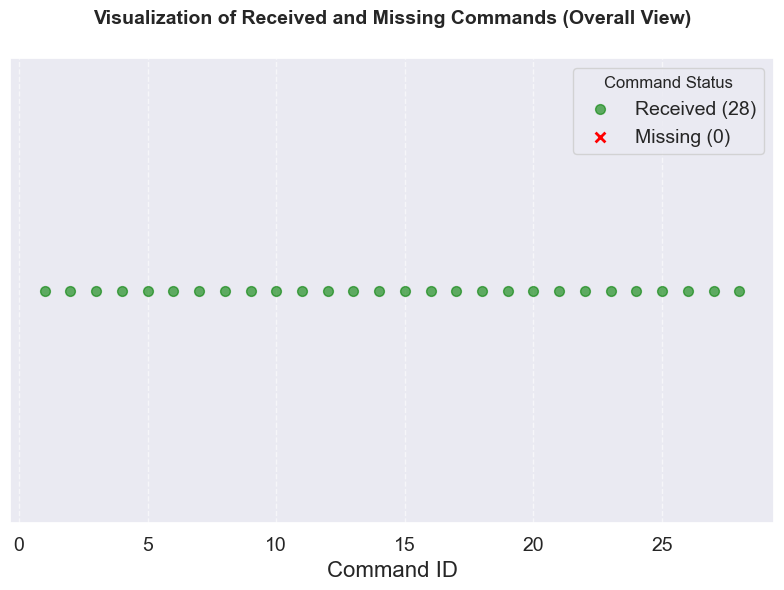

In [27]:
# 4.2 Analysis of missing commands
if not command_df.empty:
    # Find the first and last command IDs
    first_command_id = command_df['command_id'].min()
    last_command_id = command_df['command_id'].max()

    # Calculate the total number of expected commands
    total_expected_commands = last_command_id - first_command_id + 1

    # Calculate the number of received commands
    received_commands_count = len(command_df)

    # Calculate the number of missing commands
    missing_commands_count = total_expected_commands - received_commands_count

    print(f"First received command ID: {first_command_id}")
    print(f"Last received command ID: {last_command_id}")
    print(f"Total expected commands in sequence: {total_expected_commands}")
    print(f"Number of received commands: {received_commands_count}")
    print(f"Number of missing commands: {missing_commands_count}")
    print(f"Missing command percentage: {(missing_commands_count/total_expected_commands)*100:.2f}%")

    # Identify the missing command IDs
    expected_command_ids = set(range(first_command_id, last_command_id + 1))
    received_command_ids = set(command_df['command_id'])
    missing_command_ids = sorted(list(expected_command_ids - received_command_ids))

    print(f"\nMissing command IDs: {missing_command_ids if missing_commands_count > 0 else 'None'}")

    # Create visualization - only upper part
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))

    # Overall view with improved markers
    all_commands = pd.DataFrame({'command_id': list(range(first_command_id, last_command_id + 1))})
    all_commands['status'] = 'Missing'
    all_commands.loc[all_commands['command_id'].isin(received_command_ids), 'status'] = 'Received'

    # Plot with larger, more visible markers
    received_data = all_commands[all_commands['status'] == 'Received']
    missing_data = all_commands[all_commands['status'] == 'Missing']

    ax.scatter(received_data['command_id'], [1]*len(received_data),
               c='green', alpha=0.6, s=50, marker='o', label=f'Received ({len(received_data)})')
    ax.scatter(missing_data['command_id'], [1]*len(missing_data),
               c='red', s=50, marker='x', label=f'Missing ({len(missing_data)})', linewidths=2)

    ax.set_title('Visualization of Received and Missing Commands (Overall View)',
                 fontsize=14, fontweight='bold', pad=25)
    ax.set_xlabel('Command ID', fontsize=16)
    ax.set_yticks([])
    ax.set_ylabel('')
    ax.legend(title='Command Status', fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.grid(True, axis='x', linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

    # Print summary statistics
    if missing_command_ids:
        print(f"\nMissing Command Analysis:")
        print(f"- First missing command: {min(missing_command_ids)}")
        print(f"- Last missing command: {max(missing_command_ids)}")
        print(f"- Average gap between consecutive missing commands: {np.mean(np.diff(missing_command_ids)):.1f}")
        print(f"- Largest gap between consecutive missing commands: {max(np.diff(missing_command_ids))}")

else:
    print("Command data is empty. Cannot perform missing command analysis.")


C:\Users\rajib\AppData\Local\Temp\ipykernel_28340\3937974279.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = plt.boxplot([command_df['latency'].values],


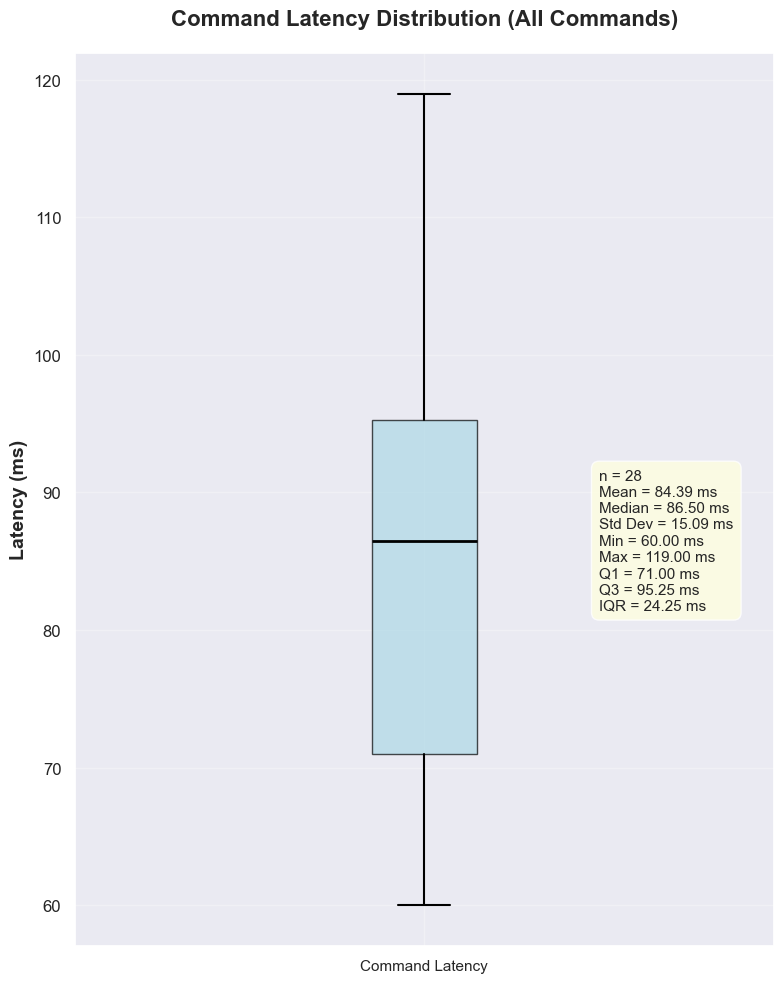

In [28]:
# 4.25 Box plot analysis of command latencies
# Create box plot for all command latencies (combined)
plt.figure(figsize=(8, 10))

# Create box plot
box_plot = plt.boxplot([command_df['latency'].values],
                        labels=['Command Latency'],
                        patch_artist=True,
                        showmeans=False,
                        medianprops=dict(color='black', linewidth=2),
                        boxprops=dict(facecolor='lightblue', alpha=0.7),
                        whiskerprops=dict(linewidth=1.5),
                        capprops=dict(linewidth=1.5))

plt.ylabel('Latency (ms)', fontsize=14, fontweight='bold')
plt.title('Command Latency Distribution (All Commands)', fontsize=16, fontweight='bold', pad=20)
plt.yticks(fontsize=12)
plt.grid(True, alpha=0.3, axis='y')

# Add statistics annotations
stats_text = f"n = {len(command_df)}\n"
stats_text += f"Mean = {command_df['latency'].mean():.2f} ms\n"
stats_text += f"Median = {command_df['latency'].median():.2f} ms\n"
stats_text += f"Std Dev = {command_df['latency'].std():.2f} ms\n"
stats_text += f"Min = {command_df['latency'].min():.2f} ms\n"
stats_text += f"Max = {command_df['latency'].max():.2f} ms\n"
stats_text += f"Q1 = {command_df['latency'].quantile(0.25):.2f} ms\n"
stats_text += f"Q3 = {command_df['latency'].quantile(0.75):.2f} ms\n"
stats_text += f"IQR = {command_df['latency'].quantile(0.75) - command_df['latency'].quantile(0.25):.2f} ms"

# Add text box with statistics
plt.text(1.25, command_df['latency'].median(), stats_text,
         fontsize=11, verticalalignment='center',
         bbox=dict(boxstyle='round,pad=0.5', facecolor='lightyellow', alpha=0.8))

plt.tight_layout()
plt.show()

In [ ]:
# 4.3 Box plot analysis of command latencies

# Group commands by type and analyze latencies
print("Command types and their counts:")
print(command_df['instruction'].value_counts())
print("\nLatency statistics by command type:")
print(command_df.groupby('instruction')['latency'].describe())

# Create box plot for command latencies by type
plt.figure(figsize=(12, 8))

# Create box plot
box_plot = plt.boxplot([command_df[command_df['instruction'] == cmd]['latency'].values 
                         for cmd in command_df['instruction'].unique()],
                        labels=command_df['instruction'].unique(),
                        patch_artist=True,
                        showmeans=False,
                        medianprops=dict(color='black', linewidth=2),
                        boxprops=dict(facecolor='lightblue', alpha=0.7),
                        whiskerprops=dict(linewidth=1.5),
                        capprops=dict(linewidth=1.5))

plt.xlabel('Command Type', fontsize=14, fontweight='bold')
plt.ylabel('Latency (ms)', fontsize=14, fontweight='bold')
plt.title('Command Latency Distribution by Command Type', fontsize=16, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, alpha=0.3, axis='y')

# Add sample size annotations
for i, cmd in enumerate(command_df['instruction'].unique(), 1):
    count = len(command_df[command_df['instruction'] == cmd])
    median_val = command_df[command_df['instruction'] == cmd]['latency'].median()
    plt.text(i, median_val, f'n={count}', 
             ha='center', va='bottom', fontsize=10, 
             bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.5))

plt.tight_layout()
plt.show()

# Print detailed statistics for each command type
print("\nDetailed statistics by command type:")
for cmd in command_df['instruction'].unique():
    cmd_data = command_df[command_df['instruction'] == cmd]['latency']
    print(f"\n{cmd}:")
    print(f"  Count: {len(cmd_data)}")
    print(f"  Mean: {cmd_data.mean():.2f} ms")
    print(f"  Median: {cmd_data.median():.2f} ms")
    print(f"  Std Dev: {cmd_data.std():.2f} ms")
    print(f"  Min: {cmd_data.min():.2f} ms")
    print(f"  Max: {cmd_data.max():.2f} ms")
    print(f"  Q1 (25%): {cmd_data.quantile(0.25):.2f} ms")
    print(f"  Q3 (75%): {cmd_data.quantile(0.75):.2f} ms")
    print(f"  IQR: {cmd_data.quantile(0.75) - cmd_data.quantile(0.25):.2f} ms")

#### 5. Hardware Usage Analysis

In [ ]:
# load file
hardware_usage = "./2026_01_21/20260116_171827_Scene_01/hw_usage_20260116_171828.json"


import ast

# read the file and parse each line safely as Python dict literal
hw_usage_data = []
with open(hardware_usage, "r") as file:
    for line in file:
        s = line.strip()
        if not s:
            continue
        try:
            hw_usage_data.append(ast.literal_eval(s))
        except Exception as e:
            print(f"Skipping malformed line: {e}")
            continue

# Display the data
print(f"Total hardware usage records loaded: {len(hw_usage_data)}")
print("\nFirst few hardware usage records:")
for i, record in enumerate(hw_usage_data[:5]):
    print(f"{i+1}. {record}")

# Convert to DataFrame for easier analysis
hw_usage_df = pd.DataFrame(hw_usage_data)
print("\nDataFrame:")
print(hw_usage_df)

In [ ]:
# 5.1 Time series analysis of CPU/RAM/Disk usage (grouped bars)
# Convert 'created_at' to datetime and aggregate per second using resample
hw_usage_df['timestamp'] = pd.to_datetime(hw_usage_df['created_at'], unit='ms')
per_second = (hw_usage_df.set_index('timestamp')
               .resample('1s').agg({
                   'cpu_usage_percent': 'mean',
                   'ram_usage_percent': 'mean',
                   'disk_usage_percent': 'mean'
               })
               .reset_index()
               .rename(columns={
                   'cpu_usage_percent': 'cpu_usage_mean',
                   'ram_usage_percent': 'ram_usage_mean',
                   'disk_usage_percent': 'disk_usage_mean'
               }))

# Integer x-axis (seconds since start) for grouped bars
per_second['time_offset'] = (per_second['timestamp'] - per_second['timestamp'].min()).dt.total_seconds().astype(int)
x = np.arange(len(per_second))
cpu = per_second['cpu_usage_mean'].values
ram = per_second['ram_usage_mean'].values
disk = per_second['disk_usage_mean'].values

# Plot grouped bar chart
plt.figure(figsize=(16, 6))
bar_w = 0.28
plt.bar(x - bar_w, cpu, width=bar_w, alpha=0.9, color='steelblue', edgecolor='navy', linewidth=0.4, label='CPU (%)')
plt.bar(x,          ram, width=bar_w, alpha=0.9, color='seagreen', edgecolor='darkgreen', linewidth=0.4, label='RAM (%)')
plt.bar(x + bar_w, disk, width=bar_w, alpha=0.9, color='darkorange', edgecolor='saddlebrown', linewidth=0.4, label='Disk (%)')

plt.title('Resource Usage per Second (Mean)', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Time offset (s)', fontsize=12)
plt.ylabel('Usage (%)', fontsize=12)
plt.grid(True, axis='y', alpha=0.3)
plt.legend(fontsize=10, ncol=3, frameon=True)

# Reduce x tick clutter
if len(x) > 0:
    max_idx = len(x) - 1
    tick_positions = np.linspace(0, max_idx, num=min(12, len(x))).astype(int)
    tick_labels = per_second.loc[tick_positions, 'time_offset'].astype(int).tolist()
    plt.xticks(tick_positions, [str(t) for t in tick_labels])

plt.tight_layout()
plt.show()

# Print quick stats
print("\nPer-second mean usage stats:")
print(f"  Seconds: {len(per_second)}")
print(f"  CPU  -> mean {per_second['cpu_usage_mean'].mean():.2f}%, min {per_second['cpu_usage_mean'].min():.2f}%, max {per_second['cpu_usage_mean'].max():.2f}%")
print(f"  RAM  -> mean {per_second['ram_usage_mean'].mean():.2f}%, min {per_second['ram_usage_mean'].min():.2f}%, max {per_second['ram_usage_mean'].max():.2f}%")
print(f"  Disk -> mean {per_second['disk_usage_mean'].mean():.2f}%, min {per_second['disk_usage_mean'].min():.2f}%, max {per_second['disk_usage_mean'].max():.2f}%")